# Respiratory Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?

    4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

<div class="alert alert-block alert-success">
    <div style="font-size: 30px">
    <b> Libraries </b> 
</div>

All used libraries imported here.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import sklearn

from statistics import mean
from scipy import linalg 
from scipy.interpolate import interp1d
from scipy.interpolate import barycentric_interpolate
from scipy import fft, signal, interpolate, fftpack
from sklearn import preprocessing

<div class="alert alert-block alert-success">
    <div style="font-size: 30px">
    <b> Most used variables  </b> 
</div>


Most important and frequently used variables are listed and assigned here. Some of them are constant during project while the others changed during project.

In [2]:
# List of datafiles' name
data_files = ['center_sternum.txt' , '1_Stave_supine_static.txt' , '2_Mattress_supine.txt' , '3_Subject_sitting_chair.txt' , 
             '4_Chest_sweater.txt' , '5_Under_chair.txt']
# List of configuration files
config_files = ['config_1.txt' , 'config_5.txt']

# Deliminator character which is used in data files
data_deliminator = '\t'

# list of desired columns
Acc = ['AccX', 'AccY', 'AccZ']
Magn = ['GyroX', 'GyroY', 'GyroZ']
Gyro = ['MagnX', 'MagnY', 'MagnZ']

data_columns = [Acc , Magn , Gyro]

# Selected features. Analysis will implemented just on this features. By default, we use all features.
selected_features = Acc + Magn + Gyro


# List of colors
colors = ['seagreen', 'seagreen', 'seagreen',
          'royalblue', 'royalblue', 'royalblue',
          'mediumpurple', 'mediumpurple', 'mediumpurple']

# Time window of Useful data in seconds (start and end second). Analysis will execute on this portion of data.
twnd = [10 , 70]

<div class="alert alert-block alert-success">
    <div style="font-size: 30px">
    <b> Functions  </b> 
</div>

These functions are prepared for easier analysing of the other data files. They are same as what we do for the first file. In each part of the first file analysis we mentioned that which function should be used and how it is implemented.

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
    <b> Function: load_df </b> 
</div>

In [3]:
def load_df(_db_name , _deliminator, **kwargs):
    
    """
    load_df returns useful columns of data file.

    Parameters
    ----------
    _db : String
        Data file name.
    _deliminator : String
        Deliminator of the columns in _db.
    **kwargs : TYPE
        Optional arguments as follow:
        _col : List[String], optional
            List of columns which are returned.
            The default is ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ'].
            'all' means do not drop any column.

    Returns
    -------
    _df : pandas.Dataframe
        Returns columns from _db file.
    _fs : integer
        Sampling frequency.
    _timestamp : [pandas.datetime]
        Sampling start and end time in a 2x1 list.

    """
    
    _col = kwargs.get('col' , ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ'])
    
    _df = pd.read_csv(_db_name, delimiter = _deliminator)
    _fs = _df['Log Freq'][0]
    _timestamp = pd.to_datetime([_df.iloc[0]['Timestamp'] , _df.iloc[-1]['Timestamp']] , unit='s')
    if _col != 'all':
        _df = _df[_col]
    return _df , _fs , _timestamp

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
    <b> Function: tm_stamp </b> 
</div>

In [4]:
def tm_stamp(_fs , _timestamp):
    
    """
    Prints some information from data file.

    Parameters
    ----------
    _fs : int
        Sampling Frequency.
    _timestamp : list[Start time, end Time]
        Samples timestamp information.

    Returns
    -------
    None.

    """
    
    print(f'Sampling frequency is {_fs} Hz.\n')
    print(f'Sampling start and end times are {_timestamp[0]} and {_timestamp[1]} respectively.')
    print(f'Sampling duration is {timestamp[1]-timestamp[0]} s.')    

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
    <b> Function: plt_df </b> 
</div>

In [5]:
def plt_df(_df, _fs, **kwargs):
    """
    Plots data.

    Parameters
    ----------
    _df : pandas.DataFrame
        dataframe to plot.
    _fs : int
        sampling frequency.
    **kwargs : TYPE
        Optional arguments as follow:
            ylabel : list[string]
                List of y labels. The deault is _df.columns.
            xlabel : string
                x label.
            c : list[color names]
                List of color for each row. The default is ['seagreen', 'royalblue','mediumpurple']
            w : int [start , stop]
                Start and end of selected window. The default is None (no window to show)
            fign : int [#rows , #columns]
                Number of subpolots. The default is [3 , 3].
            figs : int [width , hight]
                Figures' size. The default is [16 , 12].
            g : Bool
                Grid status. The default is True.
            x : list
                List of x points. By default it is generated based on the size of dataframe and fs.
            xlimit : list
                X axis limitations. The default is None.
            ylimit : list
                Y axis limitations. The default is None.

    Returns
    -------
    None.

    """
    _ylabels = kwargs.get('ylabel', _df.columns)
    _xlabel = kwargs.get('xlabel','Time(s)')
    _colors = kwargs.get('c', ['seagreen', 'royalblue','mediumpurple'])
    _wnd = kwargs.get('w', None)
    _fign = kwargs.get('fign', [3 , 3])
    _figs = kwargs.get('figs', [16 , 12])
    _grid = kwargs.get('g',True)
    _x = kwargs.get('x', None)
    _xlim = kwargs.get('xlimit', None)
    _ylim = kwargs.get('ylimit', None)
    _p = kwargs.get('peak', False)
    
    if _x is None:
        _x = np.linspace(_df.index.start/_fs, _df.index.stop/_fs, _df.shape[0])
        
    
    fig, axs = plt.subplots(_fign[0] , _fign[1], figsize = (_figs[0], _figs[1]))
    for i, ax in enumerate(axs.flat):
        ax.plot(_x, _df[_ylabels[i]], color = _colors[i//3])
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabels[i])
        ax.grid(_grid)
        
        if not(_ylim is None):
            ax.set_ylim(_ylim)

        if not(_xlim is None):
            ax.set_xlim(_xlim)
            
        if _wnd != None:
            ax.axvline(x = _wnd[0], color = 'r', linewidth=2, linestyle='--')
            ax.axvline(x = _wnd[1], color = 'r', linewidth=2, linestyle='--')
            
        
        if _p:
            _d = np.array(_df.iloc[:,i])
            ax.plot(np.abs(_x[_d.argmax()]), _d[_d.argmax()], '*', color='r')

            
    return fig, axs

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
    <b> Function: calib_df </b> 
</div>

In [6]:
def calib_df(_df , _col  , **kwargs):
    """
    This function calibrates dataframe usoing calibration coefficients and offset values.

    Parameters
    ----------
    _df : pandas.DataFrame
        Main data.
    _col : TYPE
        DESCRIPTION.

    **kwargs : TYPE
        Optional arguments as follow:
            c : np.array
                List of calibration coefficients. The default is np.eye(len(_col)).
            o : np.array
                List of offset values. The default is np.zeros(len(_col)).

    Returns
    -------
    _df : TYPE
        DESCRIPTION.

    """

    _calib = kwargs.get('c', np.eye(len(_col)))
    _offset = kwargs.get('o', np.zeros(len(_col)))
    
    _df[_col] = np.dot(_df[_col] , _calib.T) + _offset
    return _df

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
    <b> Function: statistic_df </b> 
</div>

In [7]:
def statistic_df(_df):
    """
    Returns statistical and correlation analysis results of data.

    Parameters
    ----------
    _df : pandas.DataFrame
        Data to be analysed.

    Returns
    -------
    _statistic : pandas.DataFrame
        Statistical analysis result.
    _corr : pandas.DataFrame
        Correlation analysis result.

    """
    
    
    
    # _statistic = pd.DataFrame({'Mean': _df.mean(),
    #                       'Median': _df.median(),
    #                       'Variance': _df.var(),
    #                       'Standard deviation': _df.std(),
    #                       '25% percentile': _df.quantile(q = 0.25),
    #                       '75% percentile': df.quantile(q = 0.75)})
    
    
    _statistic = _df.describe()
    _corr = _df.corr()
    
    return _statistic , _corr

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
<b> Function: Fanalysis_df </b> 
</div>

In [8]:
def Fanalysis_df(_df, _fs, **kwargs):
    """
    Calculates FFT of the given dataframe.

    Parameters
    ----------
    _df : pandas.DataFrame
        Input data to calculate fft on it.
    _fs : int
        Sampling frequency.
    **kwargs : string
        Optional arguments as follow:
            rb : Boolean
                If True the bias will be removed (set power of freq=0 to zero). Default is True.
            pf : Boolean
                If True negetive frequencies and their related FFT removed from return result. Default is False.

    Returns
    -------
    _fft_df : pandas.DataFrame
        FFT of input dataframe.
    _fft_power : pandas.DataFrame
        Power of FFT of input dataframe.
    _freq : list
        List of frequency of FFT.

    """
    
    _remove_bias = kwargs.get('rb' , True)
    _pos_freq = kwargs.get('pf' , False)
    
    def f1(x):
        return sp.fft.fft(np.array(x))
    _fft_df = _df.apply(f1)
    _freq = fft.fftfreq(_fft_df.shape[0] , d=1/_fs) 
    

    if _remove_bias:
        _fft_df.iloc[0] = 0    

    _fft_power = _fft_df.apply(np.abs)

    _fft_df['freq'] = _freq
#    _fft_df = _fft_df.sort_values(by=['freq'])
    
#    _fft_power['freq'] = _freq
#    _fft_power = _fft_power.sort_values(by=['freq'])
#    _df_freq = np.array(_df['freq'])
#    _df.drop('freq',axis=1)
    
    
    


    if _pos_freq:
        _fft_df = _fft_df.drop(_fft_df[_freq <= 0].index)
        _freq = _freq[np.where(_freq > 0)]    


    
   
    return _fft_df, _fft_power, _freq


<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
<b> Function: filter_df </b> 
</div>

In [9]:
def filter_df(_df, _fs, _cutFreq, _dfDomain='F', **kwargs):
    """
    Calculates FFT of the given dataframe.

    Parameters
    ----------
    _df : pandas.DataFrame
        Input data to calculate fft on it.
    _fs : int
        Sampling frequency.
    _cutFreq : List[Low_cut , High_cut]
        List of cutting frequencies ([Low_cut , High_cut]) of filter. 
        If [F , np.NaN] ==> Highpass filter ,cut-off freq = F
        If [0 , F] ==> lowpass filter, cut-off freq = F
        If [F1 , F2] ==> Bandpass filter, low cut-off freq = F1, high cut-off freq = F2
    _dfDomain : String
        Indicates domain of the df. It effects how the filtering will be implemented.
        'F' means frequency domain and 'T' means time domain.
    **kwargs : string
        Optional arguments as follow:
            _freq : List
                If dataframe is in frequency domain, list of frequency of df should be passed.


    Returns
    -------
    _df_filtered : pandas.DataFrame
        Filtered dataframe.

    """
    
    _freq = kwargs.get('freq' , None)
    
        
    # Frequency filtering
    def f1(x):
        x = np.array(x)
        if _cutFreq[1] == np.NaN:
            x[(np.abs(_freq) < _cutFreq[0])] = 0
        elif _cutFreq[0] == 0:
            x[(np.abs(_freq) > _cutFreq[1])] = 0
        else:
            x[(np.abs(_freq) > _cutFreq[1]) | (np.abs(_freq) < _cutFreq[0])] = 0
        return x
  
    if _dfDomain == 'F':
        if _freq is None:
            print('For frequency domain, frequenciy list should be passed as ''freq'' argument.' )
            return
        else:
            _df_filtered = _df.apply(f1)
    elif _dfDomain == 'T':
        if _cutFreq[1] == np.NaN:
            sos = signal.butter(10,  _cutFreq[0], fs=_fs, btype='highpass', output="sos")
        elif _cutFreq[0] == 0:
            sos = signal.butter(10,  _cutFreq[1], fs=_fs, btype='lowpass', output="sos")
        else:
            sos = signal.butter(10,  _cutFreq, fs=_fs, btype='bandpass', output="sos")
        
        
        _df_filtered = _df.apply(lambda x: np.real(signal.sosfilt(sos,x))).copy()
#        real_filtered_df = filtered_df.apply(np.real)


    return _df_filtered


<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
<b> Function: method1 </b> 
</div>

In [10]:
def method1(_df, _fs, _filter_freq,  **kwargs):
    
    _features = kwargs.get('features' , _df.columns)
    
    
    # Removing bias of signals
    _df -= _df.mean()
    
    # Calculating FFT
    df_fft, df_fft_pwr, df_freq = Fanalysis_df(_df, _fs)

    # Filtering
    _df_filtered = filter_df(df_fft.copy(), _fs, _filter_freq, freq=df_freq)    
    _df_filtered_pwr = _df_filtered.apply(np.abs)
    # Calculating peak frequencies 
    def f1(x):
        return x.argmax()
    
    peak_freq = np.abs(df_freq[_df_filtered_pwr.apply(f1)])
    
    # Calculating RR based on most repeated peak frequency
    F, F_counts = np.unique(peak_freq , return_counts=True)
    F = list(zip(F,F_counts))
    F = sorted(F , key = lambda x: x[1], reverse=True)

    print(f'RR frequency is {F[0][0]:.3f} Hz, which is equal to {F[0][0]*60:.0f} breath per minute.')
    
    ##############################################
    
    df_fft_pwr['freq'] = df_freq
    df_fft_pwr = df_fft_pwr.sort_values(by=['freq'])

    _df_filtered_pwr['freq'] = df_freq
    _df_filtered_pwr = _df_filtered_pwr.sort_values(by=['freq'])
    
    df_freq = np.array(df_fft_pwr['freq'])
    df_fft_pwr.drop('freq', axis=1)
    _df_filtered_pwr.drop('freq', axis=1)    
 
    
    filtered_sig = _df_filtered.apply(lambda x: np.real(sp.fft.ifft(np.array(x))))
    minima = filtered_sig.apply(lambda x: signal.argrelextrema(np.array(x), np.less, order=fs))    
       
    
    for i,c in enumerate(_features):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8), gridspec_kw={'height_ratios': [1, 3]})
        
        ax1.plot(df_freq, df_fft_pwr[c], color=colors[0], label='Original')
        ax1.plot(df_freq, _df_filtered_pwr[c], color='r', label='Filtered')
        
        ax1.set_xlim(-_filter_freq[1],_filter_freq[1])
        
        ax1.set(xlabel="Frequency (Hz)", ylabel="Power",title="Filtered FFT on " + c)
        ax1.grid()
        ax1.legend()
        
        ############

        x = np.linspace(_df.index.start/_fs, _df.index.stop/_fs, _df.shape[0])
        
        _p = x[list(minima[c][0])]
        
        ax2.plot(x, _df[c], alpha=0.5, color=colors[i], label='Original')
        ax2.plot(x, filtered_sig[c], linewidth=0.5, color='r', label='Filtered')

        ax2.set_xlabel('Time')
        ax2.set_ylabel(c)
        ax2.set_title(f'Original and Filtered {c} (RR={_p.size})')
        ax2.grid()
        ax2.legend()
        
        
        for j in _p:
            ax2.axvline(j, color = 'r', linewidth=2, linestyle='--')

        plt.tight_layout(pad=3.0)
        plt.show()
        
        
    return list(zip(F,F_counts))
    

<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
<b> Function: method2 </b> 
</div>

In [11]:
def method2(_df , _fs, _filter_freq, _twnd, **kwargs):
    
    _features = kwargs.get('features' , _df.columns)
    _no_filter = kwargs.get('nofilter', False)

    if not _no_filter:
        _df_filtered = filter_df(_df.copy(), _fs, _filter_freq, 'T')
    else:
        _df_filtered = _df.copy()


    _df_filtered = _df_filtered.iloc[_twnd[0]*_fs:_twnd[1]*_fs, :].copy()    
    _df_filtered = pd.DataFrame(preprocessing.normalize(_df_filtered, axis=0), columns=_df_filtered.columns)
    

    moving_avg =_df_filtered.apply(lambda x: x.rolling(window=fs).mean())
    max_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))

    def f2(x, A, nu, B):
        return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency    

    x = np.linspace(0, _df_filtered.index.stop/_fs, _df_filtered.index.stop)
  
    
    RR_mva = []
    for i,c in enumerate(_features):
        fig, ax = plt.subplots(1, 1, figsize = (14, 4))

        _p = [x+_df_filtered.index.start for x in list(max_mva[c][0])]
        _d = moving_avg[c] 
      

        popt, pcov = sp.optimize.curve_fit(f2, x[_p], _d[_p])
    
        RR_mva.append(60*popt[1]/np.pi/2)
        print(f'{c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
        
        
        xx = x[_df_filtered.index.start:]
        
        ax.plot(xx , _df_filtered[c], alpha=0.5, color=colors[i], label='Filtered')
        ax.plot(xx , _d, color='yellow', linewidth=0.5, label='Moving Average')  
        ax.plot(x[_p], _d[_p],'*',color='red', label='Maximums of moving average')
        ax.plot(xx, f2(xx, popt[0], popt[1], popt[2]), color='orange',linestyle='--', label='Fitted Function')

        ax.set_xlabel('Time(s)')
        ax.set_ylabel(c)
        ax.set_title(f'Original, Filtered and moving average of {c} (RR={RR_mva[i]:.0f})')
        ax.legend()
        ax.grid() 
    


    print(25*'*')
    print(f'Calculated RR by using moving average in time domain is {mean(RR_mva):2.0f} bpm. ')
    
    return RR_mva


<div class="alert alert-block alert-warning">
    <div style="font-size: 20px">
<b> Function: method3 </b> 
</div>

In [12]:
def method3(_df , _fs, _filter_freq, _twnd, **kwargs):
    
    _features = kwargs.get('features' , _df.columns)
    _no_filter = kwargs.get('nofilter', False)

    if not _no_filter:
        _df_filtered = filter_df(_df.copy(), _fs, _filter_freq, 'T')
    else:
        _df_filtered = _df.copy()

    _df_filtered = _df_filtered.iloc[_twnd[0]*_fs:_twnd[1]*_fs, :].copy()    
    _df_filtered = pd.DataFrame(preprocessing.normalize(_df_filtered, axis=0), columns=_df_filtered.columns)
    

    max_sig = _df_filtered.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))

    def f2(x, A, nu, B):
        return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency    

    x = np.linspace(0, _df_filtered.index.stop/_fs, _df_filtered.index.stop)
  
    
    RR_sig = []
    for i,c in enumerate(_features):
        fig, ax = plt.subplots(1, 1, figsize = (14, 4))

        _p = [x+_df_filtered.index.start for x in list(max_sig[c][0])]
        _d = _df_filtered[c] 
      

        popt, pcov = sp.optimize.curve_fit(f2, x[_p], _d[_p])
    
        RR_sig.append(60*popt[1]/np.pi/2)
        print(f'{c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
        
        
        xx = x[_df_filtered.index.start:]
        
        ax.plot(xx , _df_filtered[c], alpha=0.5, linewidth=0.5,color=colors[i], label='Filtered')
#        ax.plot(xx , _d, color='yellow', label='Moving Average')  
        ax.plot(x[_p], _d[_p],'*',color='red', label='Maximums of signal')
        ax.plot(xx, f2(xx, popt[0], popt[1], popt[2]), color='orange', linestyle='--', label='Fitted Function')

        ax.set_xlabel('Time(s)')
        ax.set_ylabel(c)
        ax.set_title(f'Original, Filtered and moving average of {c} (RR={RR_sig[i]:.0f})')
        ax.legend()
        ax.grid() 
    


    print(25*'*')
    print(f'Calculated RR by using moving average in time domain is {mean(RR_sig):2.0f} bpm. ')
    
    
    return RR_sig


<div class="alert alert-block alert-success">
    <div style="font-size: 30px">
    <b> Analysis  </b> 
</div>

<div class="alert alert-block alert-warning">
    <div style="font-size: 30px">
    <b> Analysis of the first file: ""center_sternum.txt""  </b> 
</div>

# 1. Data preparation

## 1.1. Loading data

**load_df** function is used for loading data file to the memory. By default it drops all columns except *['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']*, However it is possible to select other columns by sending them as 'col' parameter.

In [13]:
df , fs , timestamp = load_df(data_files[0], data_deliminator)
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178
1,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177
2,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177
3,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176
4,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176
...,...,...,...,...,...,...,...,...,...
16501,958.493,291.092,-54.290,1.664122,2.305344,-0.671756,-494,-449,-126
16502,954.650,288.042,-49.654,1.480916,2.488550,-0.702290,-494,-450,-125
16503,967.338,290.482,-63.867,1.114504,3.374046,-0.900763,-494,-450,-125
16504,965.630,300.852,-56.242,0.702290,3.664122,-1.587786,-495,-448,-124


General information about data files including sampling frequency, sampling time and duration obtained from related columns.

In [14]:
tm_stamp(fs, timestamp)

Sampling frequency is 200 Hz.

Sampling start and end times are 2019-12-13 07:39:32 and 2019-12-13 07:40:47 respectively.
Sampling duration is 0 days 00:01:15 s.


## 1.2. Ploting raw data

Ploting raw data helps to select useful portion of it for analysing. Following codes are wrapped in the **plt_df** function.

In [15]:
#fig, axs = plt_df(df , fs ,  w = twnd)

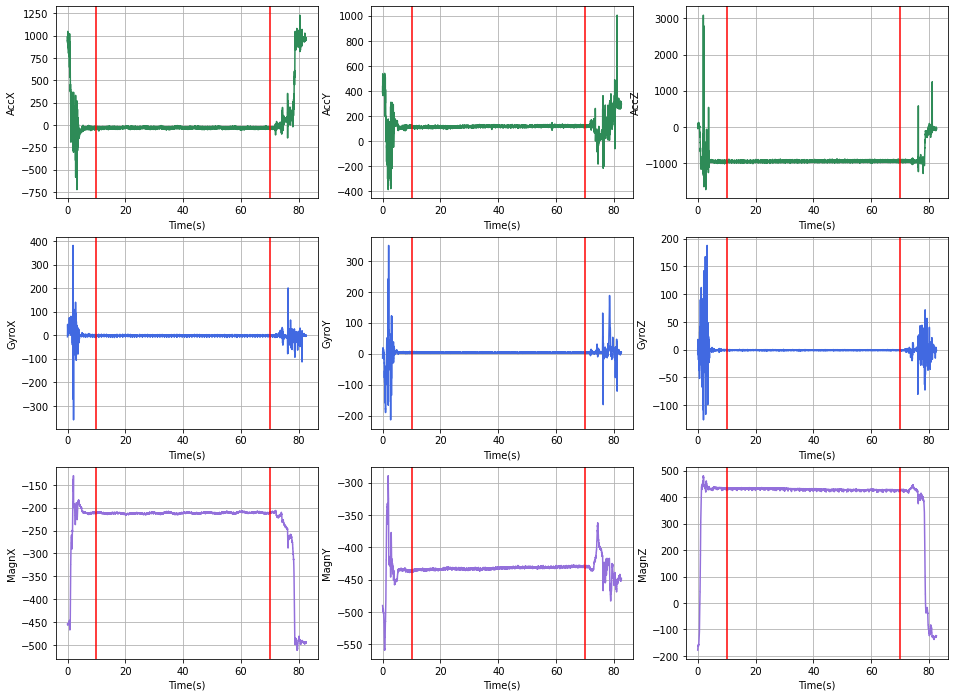

In [16]:
x = np.linspace(0, df.shape[0] / fs, df.shape[0])

y_label = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'MagnX', 'MagnY', 'MagnZ']
colors = ['seagreen', 'seagreen', 'seagreen', 'royalblue', 'royalblue', 'royalblue', 'mediumpurple', 'mediumpurple', 'mediumpurple']

fig, axs = plt.subplots(3, 3, figsize = (16, 12))
for i, ax in enumerate(axs.flat):
    ax.plot(x, df[y_label[i]], color = colors[i])
    ax.axvline(x = 10, color = 'r')
    ax.axvline(x = 70, color = 'r')
    ax.set_xlabel('Time(s)')
    ax.set_ylabel(y_label[i])
    ax.grid()

## 1.3. Calibration

Calibration info prepared in the related configuration file. 

In [17]:
gyro_offset = np.array([-2.242224,2.963463,-0.718397])

acc_cal = np.array([[1.000966,-0.002326418,-0.0006995499],
                    [-0.002326379,0.9787045,-0.001540918],
                    [-0.0006995811,-0.001540928,1.00403]])
acc_offset = np.array([-3.929942,-13.74679,60.67546])

magn_cal = np.array([[0.9192851,-0.02325168,0.003480837],
                   [-0.02325175,0.914876,0.004257396],
                   [0.003481006,0.004257583,0.8748001]])
magn_offset = np.array([-95.67974,-244.9142,17.71132])

 Following codes are wrapped in the **calib_df** function.

In [18]:
#df = calib_df(df , Acc , c = acc_cal , o = acc_offset)
#df = calib_df(df , Magn , c = magn_cal , o = magn_offset)
#df = calib_df(df , Gyro , o = gyro_offset)
#df

In [19]:

df[['GyroX','GyroY','GyroZ']] = df[['GyroX','GyroY','GyroZ']] + gyro_offset
df[['AccX','AccY','AccZ']] = np.dot(df[['AccX','AccY','AccZ']], acc_cal.T) + acc_offset
df[['MagnX','MagnY','MagnZ']] = np.dot(df[['MagnX','MagnY','MagnZ']], magn_cal.T) + magn_offset

df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
0,943.007996,410.325442,130.264244,-9.066652,-11.280817,0.686183,-502.261441,-683.404962,-141.669690
1,965.209969,363.380701,148.635086,3.940982,-9.326617,-8.687863,-502.257960,-683.400705,-140.794890
2,985.689106,356.065246,138.465450,9.467696,-1.998369,-8.168779,-502.257960,-683.400705,-140.794890
3,950.852176,393.026437,148.047237,15.635636,5.482547,-6.703130,-502.207976,-685.226199,-139.928605
4,968.040164,402.461108,159.595720,22.979146,8.368043,3.296870,-502.207976,-685.226199,-139.928605
...,...,...,...,...,...,...,...,...,...
16501,954.849739,269.000099,5.047576,-0.578102,5.268807,-1.390153,-539.805161,-644.743591,-96.144764
16502,951.006879,266.016847,9.709647,-0.761308,5.452013,-1.420687,-539.778428,-645.654210,-95.274222
16503,963.711402,268.397270,-4.573267,-1.127720,6.337509,-1.619160,-539.778428,-645.654210,-95.274222
16504,961.972293,278.538659,3.067677,-1.539934,6.627585,-2.306183,-540.740736,-643.796949,-94.394388


## 1.4. Useful portion of data

First and last 10 seconds are very noisy, so we will remove those data from the dataset.

In [20]:
# Selecting data between seconds 10 and 70.
# index number is obtained by multiplying time and sampling frequency.
twnd = [10, 70]
df2 = df.iloc[twnd[0]*fs:twnd[1]*fs , :].copy()
df2

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,-36.191918,98.305357,-897.115495,-0.486499,7.986364,-1.527557,-278.856972,-639.776198,393.017911
2001,-22.684157,97.764133,-915.007862,-0.684972,7.161936,-1.802366,-278.856972,-639.776198,393.017911
2002,-31.003173,96.009994,-887.561201,-1.310926,7.284074,-1.817634,-278.021365,-637.071851,389.534964
2003,-25.334931,99.274992,-884.079327,-1.295659,7.100867,-1.985573,-278.021365,-637.071851,389.534964
2004,-35.980596,103.453468,-867.603353,-1.219323,7.665753,-1.710763,-278.876743,-638.857065,393.896969
...,...,...,...,...,...,...,...,...,...
13995,-40.052097,98.944783,-880.026254,-5.387262,6.429112,-1.329084,-278.141105,-632.501729,388.681452
13996,-34.443708,104.012984,-884.386623,-5.417797,6.322242,-1.497023,-277.245071,-631.610104,388.689191
13997,-36.395733,103.541515,-885.425685,-5.234590,6.642852,-1.268015,-277.245071,-631.610104,388.689191
13998,-26.245083,99.049690,-891.489056,-5.265125,6.749723,-1.283282,-278.117853,-633.416605,388.677195


## 1.5. Plot useful data

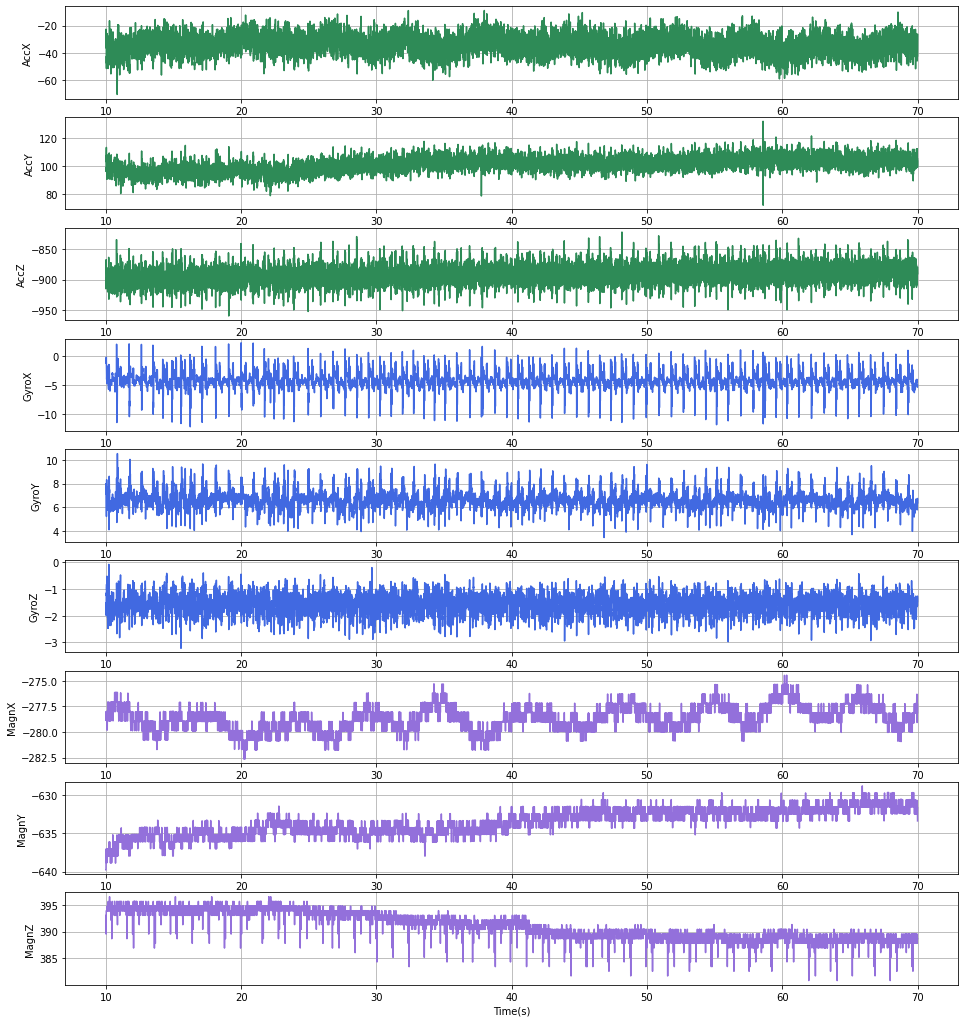

In [21]:
fig, axs = plt_df(df2, fs, fign=[9,1], figs=[16,18])

## 1.5. Feature selection

Feature selection has many advantages for analysis, especially it can reduce the cost of analysis by reducing the computational load (especially in big data). At the same time, a mistake in choosing the features causes an error in the final result and even its failure. Therefore, in choosing the features, the utmost care must be taken.

From the plotted signals it is seen that 'AccX', 'GyroY', 'MagnX' are probably best signals for RR calculation. However, it is a good idea to using reducing feature methods such as PCA. Since our data is not too big, we executed our algorithms on all features.

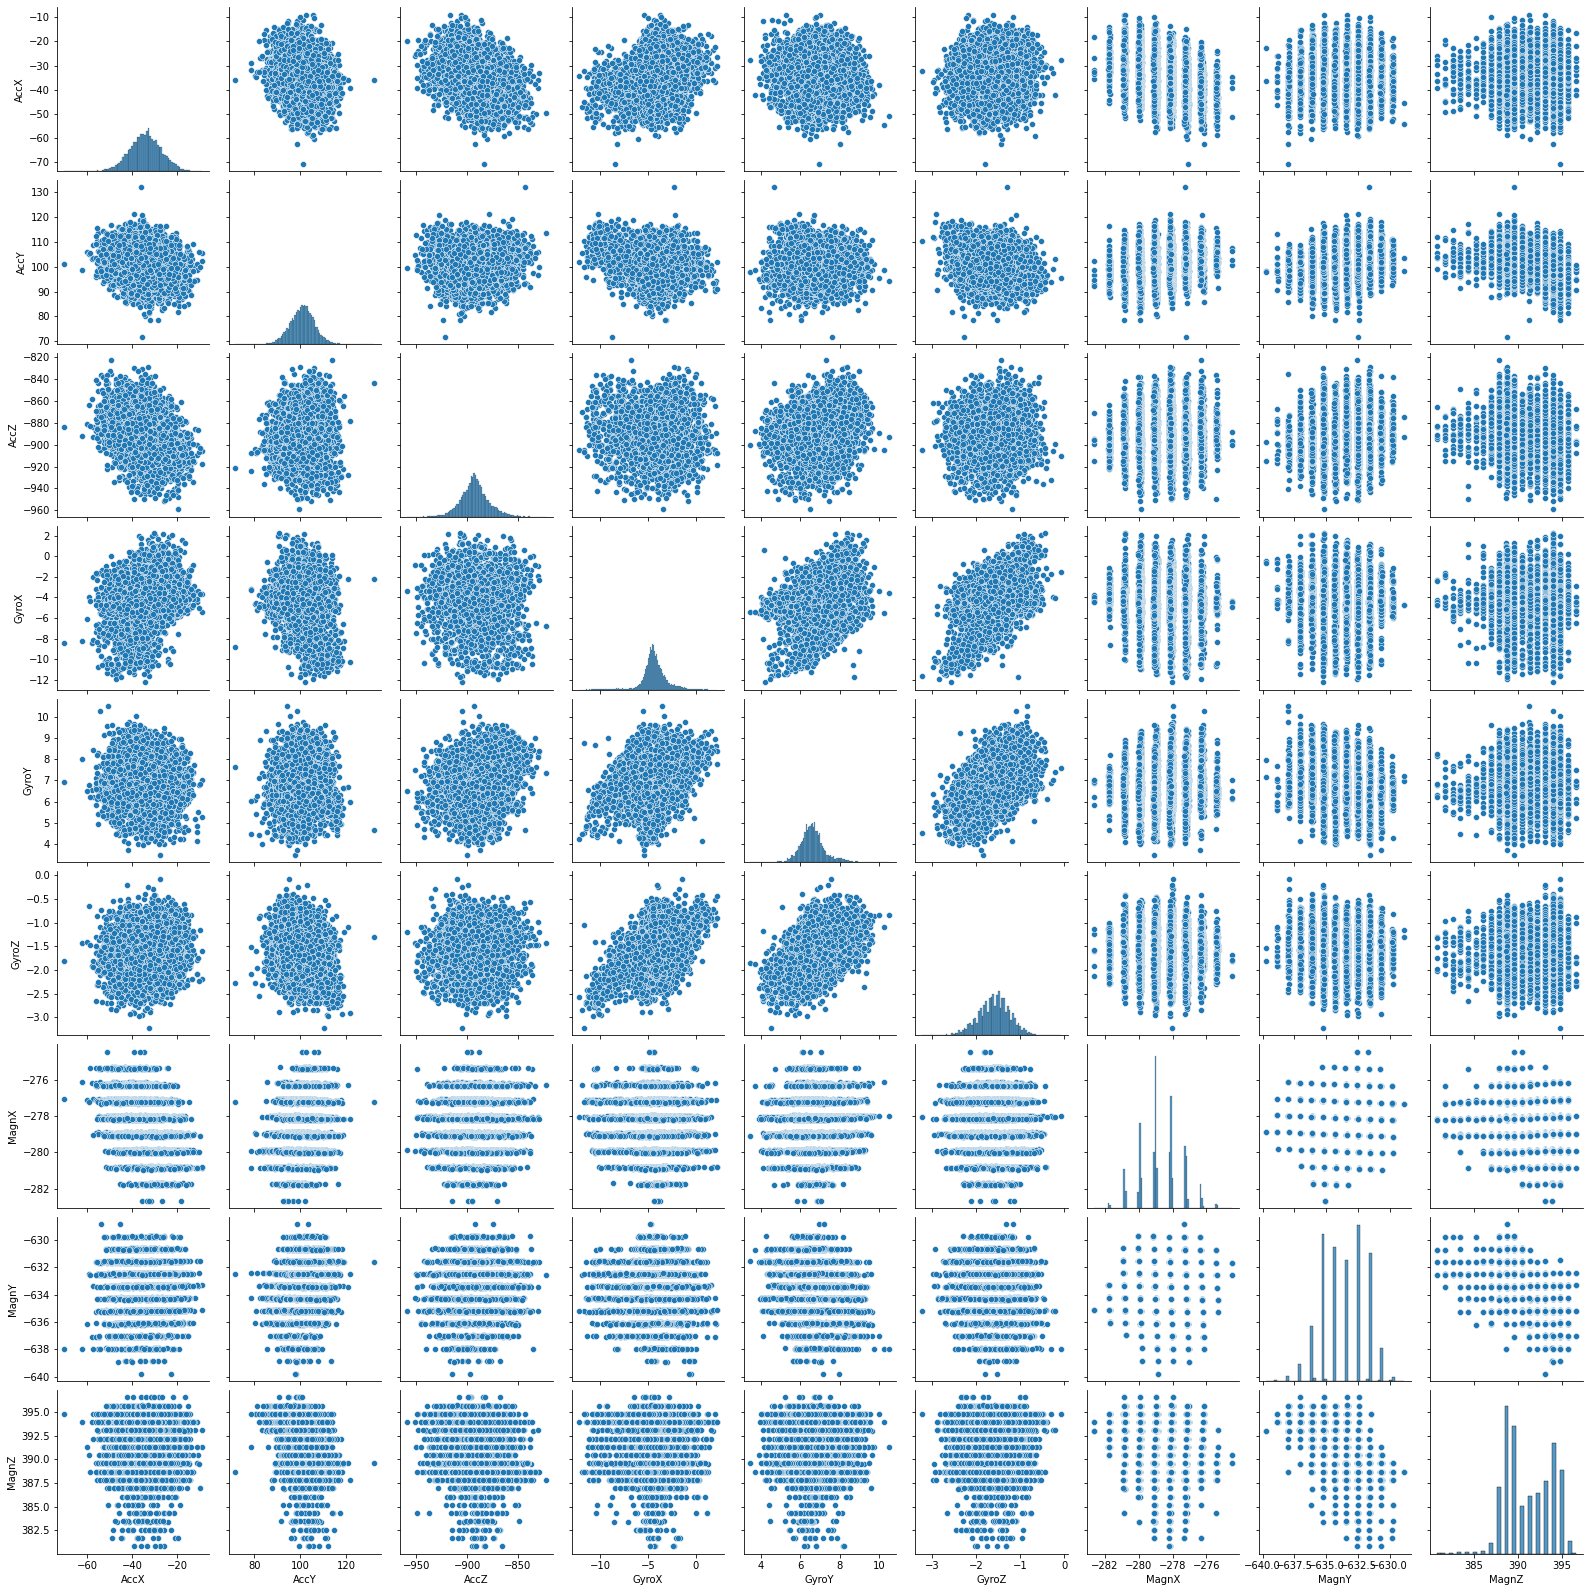

In [22]:
sns.pairplot(df2)

# 2. Time and Frequency Analysis

## 2.1. Statistical Analysis

Statistical analysis using *describe* and *corr* builtin functions are wrapped in **statistic_df** function.

### 2.1.1. Mean, median, variance, standard deviation, 25th and 75th percentiles

In [23]:
#statistic_df , corr_df = statistic_df(df2)
#statistic_df

In [24]:
stat = df2.describe()
stat

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,-34.234293,100.900265,-892.401054,-4.326728,6.646299,-1.587087,-278.667645,-633.583895,391.063967
std,7.018565,5.214543,14.456269,1.413005,0.712699,0.362975,1.212739,1.662086,2.553438
min,-70.523078,71.834825,-959.109087,-12.242224,3.467280,-3.222214,-282.650371,-639.776198,380.808251
25%,-38.854045,97.480937,-900.970347,-4.929247,6.245906,-1.817634,-279.106893,-635.170051,388.688414
50%,-34.158425,101.068429,-892.838259,-4.394896,6.597051,-1.573359,-278.966269,-633.408090,390.435310
75%,-29.560357,104.345627,-884.565100,-3.723140,6.963463,-1.344351,-278.050465,-632.474220,393.902779
max,-8.963639,131.953547,-822.777963,2.231058,10.520715,-0.077176,-274.460483,-628.865476,396.544210


### 2.1.2. Correlation coefficients

In [25]:
#corr_df

In [26]:
df2_corr = df2.corr()
df2_corr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
AccX,1.000000,-0.180828,-0.412005,0.203288,0.010442,0.025054,-0.386831,-0.051802,0.087693
AccY,-0.180828,1.000000,0.165032,-0.050947,-0.011371,-0.133083,0.243585,0.358844,-0.490141
AccZ,-0.412005,0.165032,1.000000,-0.079125,0.112730,0.025872,0.123488,0.190235,-0.236575
GyroX,0.203288,-0.050947,-0.079125,1.000000,0.395832,0.383160,-0.058950,-0.065203,0.026454
GyroY,0.010442,-0.011371,0.112730,0.395832,1.000000,0.436120,0.010498,-0.139320,0.027379
GyroZ,0.025054,-0.133083,0.025872,0.383160,0.436120,1.000000,-0.017122,-0.059217,0.008068
MagnX,-0.386831,0.243585,0.123488,-0.058950,0.010498,-0.017122,1.000000,0.255512,-0.326848
MagnY,-0.051802,0.358844,0.190235,-0.065203,-0.139320,-0.059217,0.255512,1.000000,-0.739075
MagnZ,0.087693,-0.490141,-0.236575,0.026454,0.027379,0.008068,-0.326848,-0.739075,1.000000


## 2.2. Normalizing data

For better performance we normalized the data.

In [27]:
#df_un = pd.DataFrame(preprocessing.normalize(df2, axis=0), columns=df2.columns)
df2n = (df2 - df2.min())/(df2.max() - df2.min())
df2n

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,0.557691,0.440304,0.454728,0.812236,0.640693,0.538835,0.463181,0.000000,0.775908
2001,0.777118,0.431302,0.323486,0.798523,0.523809,0.451456,0.463181,0.000000,0.775908
2002,0.641980,0.402124,0.524810,0.755274,0.541126,0.446602,0.565210,0.247861,0.554571
2003,0.734057,0.456433,0.550349,0.756329,0.515151,0.393204,0.565210,0.247861,0.554571
2004,0.561124,0.525937,0.671202,0.761603,0.595238,0.480583,0.460767,0.084241,0.831771
...,...,...,...,...,...,...,...,...,...
13995,0.494985,0.450940,0.580079,0.473629,0.419913,0.601942,0.550590,0.666727,0.500332
13996,0.586090,0.535244,0.548095,0.471519,0.404762,0.548544,0.659997,0.748447,0.500824
13997,0.554380,0.527401,0.540474,0.484177,0.450216,0.621359,0.659997,0.748447,0.500824
13998,0.719272,0.452685,0.495998,0.482068,0.465368,0.616505,0.553429,0.582876,0.500061


## 2.3.  Fourier Analysis

### 2.3.1. Plot normalized data

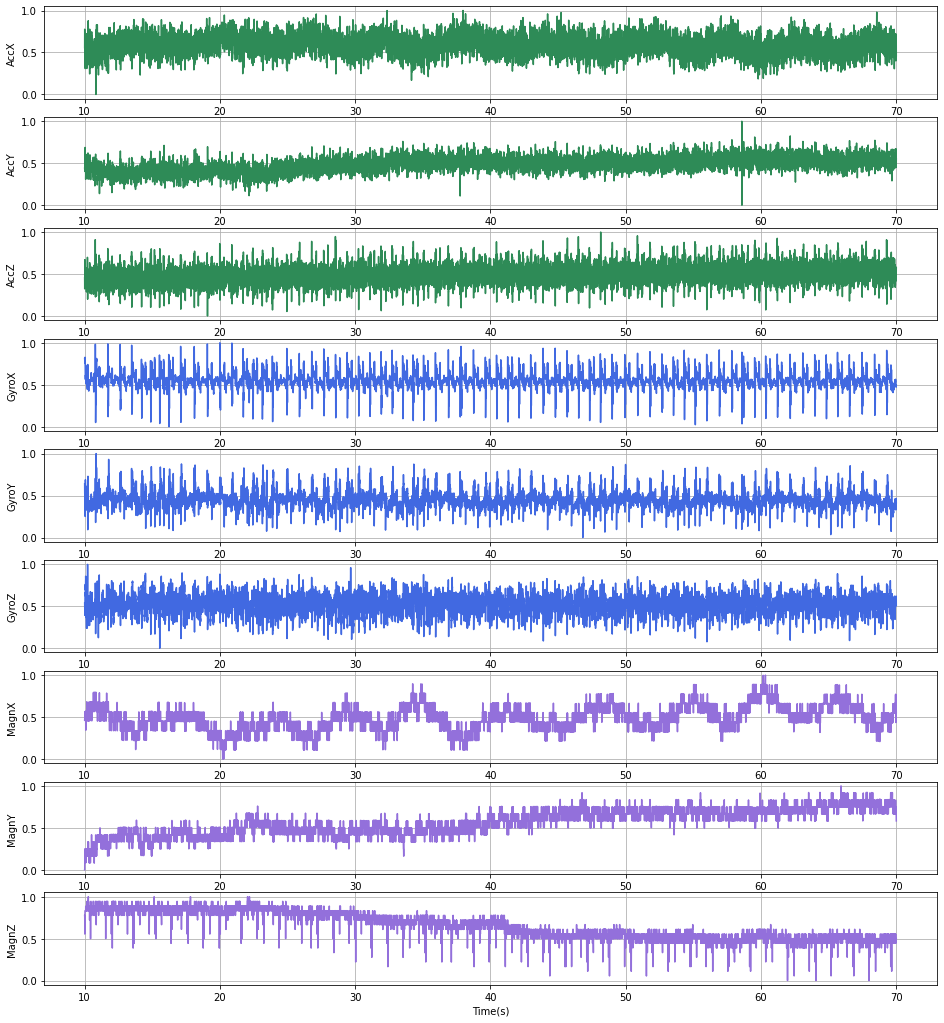

In [28]:
fig, axs = plt_df(df2n, fs, fign=[9,1], figs=[16,18])

## 2.3.2. Frequency analysis of the data

We used *scipy.fft* library for Fourier analysing of data. **Fanalysis_df** function is prepared for future use.

In [29]:
#df_fft, df_fft_pwr, df_freq = Fanalysis_df(df2n, fs)
#df_fft

In [30]:
#df_fft_pwr

In [31]:
df_fft = df2n.apply(np.fft.fft)
df_freq = fft.fftfreq(df_fft.shape[0] , d=1/fs)
df_fft_pwr = df_fft.apply(np.abs)

df_fft_pwr

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,7073.901785,5801.608304,5871.706888,6562.848293,5408.461022,6238.883773,5835.575786,6810.515548,7820.851088
2001,153.569681,330.964491,181.189423,22.537999,35.435973,24.157931,554.132469,887.836414,1119.722883
2002,93.846883,241.131696,96.946518,19.229220,16.506142,9.931451,320.081776,226.688966,326.411689
2003,36.439594,34.937722,49.887766,6.962915,16.587788,13.488979,71.367057,451.530475,227.345322
2004,66.129886,47.059877,44.483108,7.245733,13.625707,10.105011,169.142769,245.538213,146.527711
...,...,...,...,...,...,...,...,...,...
13995,24.085204,52.521432,39.910576,6.495330,13.338395,5.094621,34.250096,167.546644,171.484024
13996,66.129886,47.059877,44.483108,7.245733,13.625707,10.105011,169.142769,245.538213,146.527711
13997,36.439594,34.937722,49.887766,6.962915,16.587788,13.488979,71.367057,451.530475,227.345322
13998,93.846883,241.131696,96.946518,19.229220,16.506142,9.931451,320.081776,226.688966,326.411689


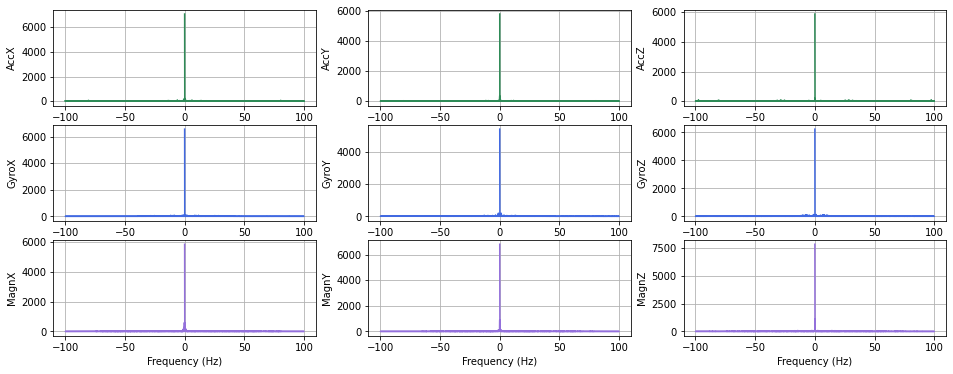

In [32]:
fig, axs = plt_df(df_fft_pwr, fs, x=df_freq, xlabel='Frequency (Hz)', figs=[16,6])

For better visualization we limit vertical and horizental axis of plots.

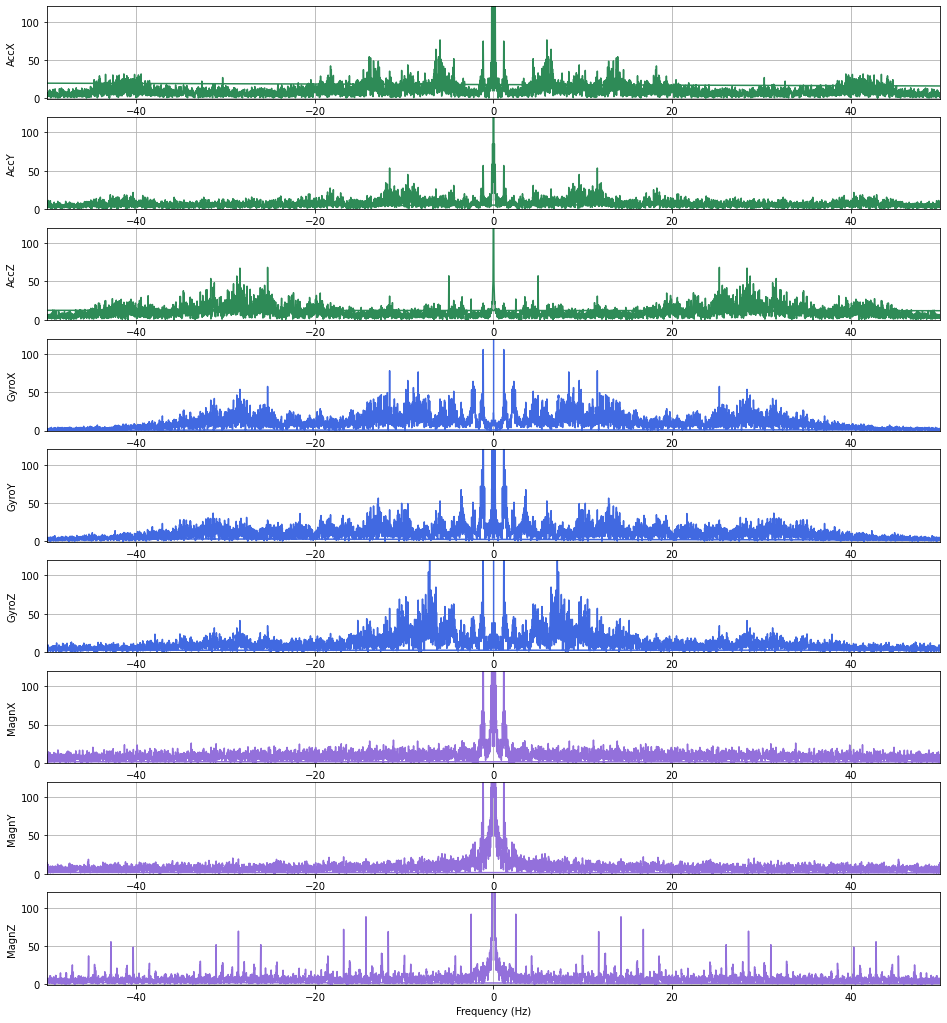

In [33]:
fig, axs = plt_df(df_fft_pwr, fs, x=df_freq, xlabel='Frequency (Hz)', fign=[9,1], figs=[16,18],
                  xlimit=[-50,50], ylimit=[-0.5,120])

From frequency spectrum it is obvious that main information is in frequencies below 40 Hz. However, different approches could be used to find HR and RR. Cut-off frequencies of filter depends on the selected approach.

# 3. Filter

Normal respiratory rate is between 10 and 20 breaths per minute for adults, while for childs it could be up to 60 breaths per minue. From these facts it is concluded that main frequencies of RR should be less than 1 Hz, which are confirmed by low-frequency high-power harmonics in the spectrum. 

Considering that our goal is to estimate the respiratory rate of a healthy subject, and we do not need a clear HR waveform or other specific properties of the HR waveform, we use a very narrow bandpass filter.

## 3.1. Filtering

For filtering we just set power of FFT in non-desired frequencies to zero.

In [34]:
filter_freq = [0.05 , 1]

In [35]:
#df_filtered = filter_df(df_fft_pwr.copy(), fs, filter_freq, freq=df_freq)

In [36]:
df_filtered = df_fft_pwr.copy()
df_filtered[(np.abs(df_freq) > filter_freq[1]) | (np.abs(df_freq) < filter_freq[0])] = 0
df_filtered

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ
2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003,36.439594,34.937722,49.887766,6.962915,16.587788,13.488979,71.367057,451.530475,227.345322
2004,66.129886,47.059877,44.483108,7.245733,13.625707,10.105011,169.142769,245.538213,146.527711
...,...,...,...,...,...,...,...,...,...
13995,24.085204,52.521432,39.910576,6.495330,13.338395,5.094621,34.250096,167.546644,171.484024
13996,66.129886,47.059877,44.483108,7.245733,13.625707,10.105011,169.142769,245.538213,146.527711
13997,36.439594,34.937722,49.887766,6.962915,16.587788,13.488979,71.367057,451.530475,227.345322
13998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


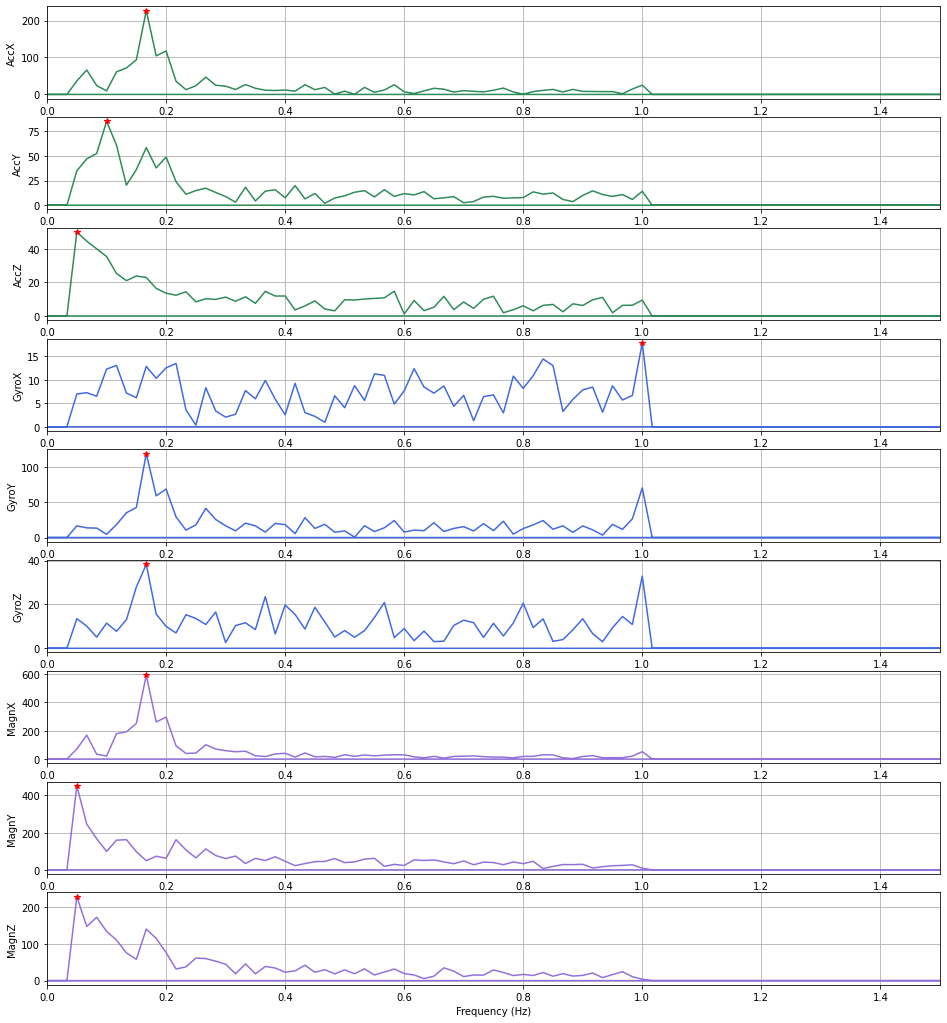

In [37]:
fig , axs = plt_df(df_filtered, fs, x=df_freq, xlabel='Frequency (Hz)',fign=[9,1], figs=[16,18], xlimit=[0,filter_freq[1]*1.5], peak=True)

As it is supposed, there is a peak in the spectrum between 0.1 and 1 Hz. We use this peak to find RR in the first method.

## 3.2. Methods to detect Respiratory Rate

## 3.2.1. Method 1

In this method we use a very narrow bandpass filter. Its cut-off frequencies are selected base on the nature of resipatory rate and spectrum of the signal. We find frequency of the peak value in the spectrum of the filtered signal of all selected features (columns). Then run a voting between them to decide between them as the final RR value for reporting. All the following codes (including filtered signal visualization) are wrapped in the **method1** function.

> **Note:** *method1 internally calculates FFT of the signal and performs filtering. So the sampling dataframe should passed to it.*

In [38]:
#method1(df2n, fs,  filter_freq, features=selected_features)

### Finding RR

In [39]:
def f1(x):
    return x.argmax()
    
peak_freq = np.abs(df_freq[df_filtered.apply(f1)])
    
# Calculating RR based on most repeated peak frequency
F, F_counts = np.unique(peak_freq , return_counts=True)
F = list(zip(F,F_counts))
F = sorted(F , key = lambda x: x[1], reverse=True)

print(f'RR frequency is {F[0][0]:.3f} Hz, which is equal to {F[0][0]*60:.0f} breath per minute.')

RR frequency is 0.167 Hz, which is equal to 10 breath per minute.


### Filtered signal visualisation

Here we show how method1 works. We just visualize the result on three features ['AccX', 'GyroY', 'MagnX'].

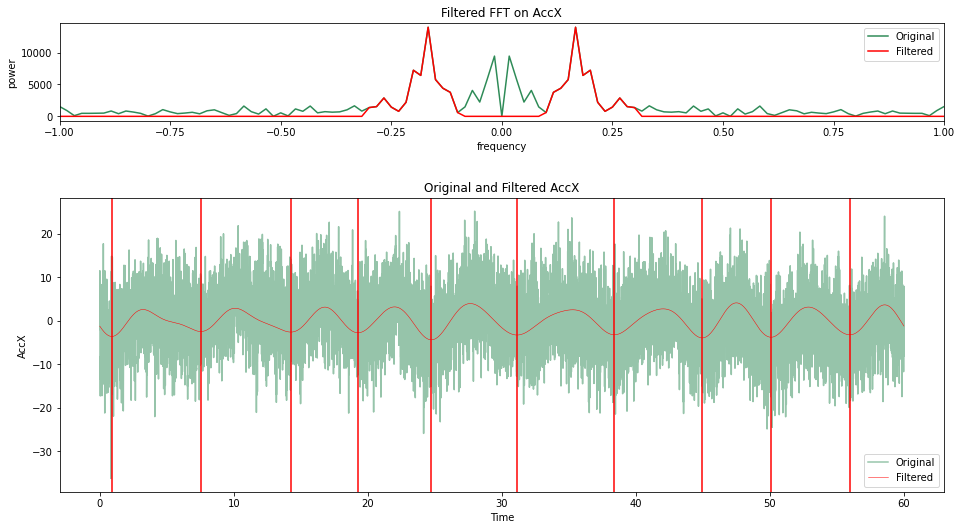

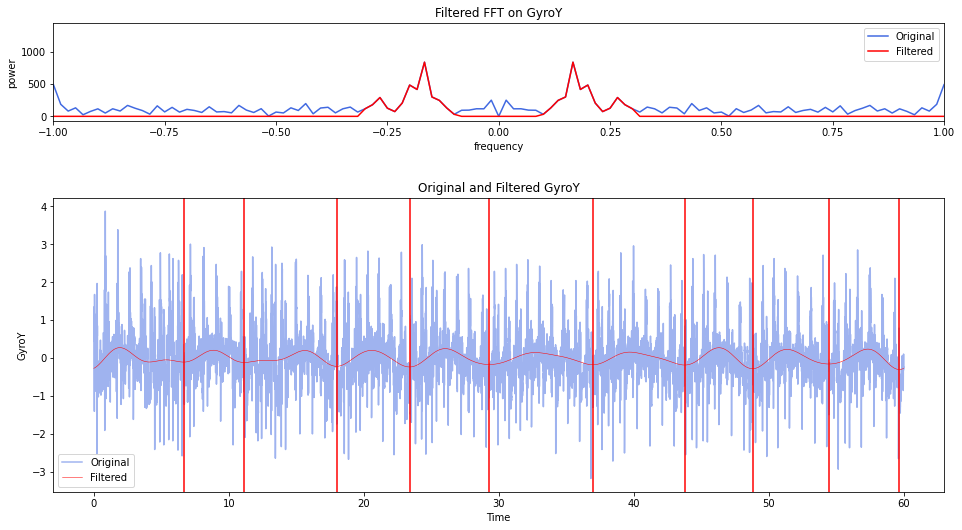

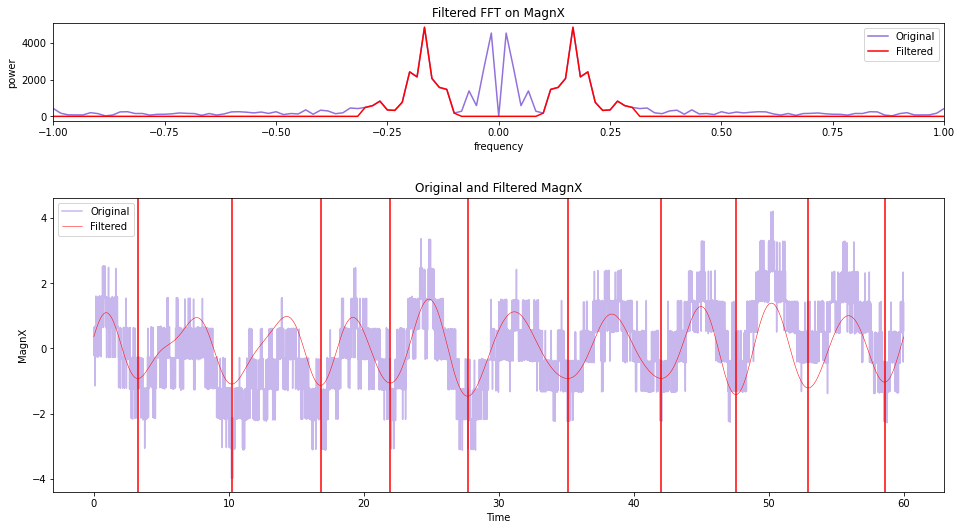

In [40]:
rr_int = [0.1, 0.3]

df3 = df.iloc[2000:14000, :].copy()
x = np.linspace(0, df3.shape[0]/fs, df3.shape[0])

def fft_calc(sig_name):
    # The FFT of the signal
    sig = df3[sig_name].to_numpy()
    sig -= np.mean(sig)
    sig_fft = fftpack.fft(sig)

    # And the power (sig_fft is of complex dtype)
    power = np.abs(sig_fft) # these are the "weights" of the Fourier components for each discrete frequency interval

    # The return the corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size, d=1/fs)
    return sig_fft, power, sample_freq

fft_y_label = ['AccX', 'GyroY', 'MagnX']

for label in fft_y_label:
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (14, 8), gridspec_kw={'height_ratios': [1, 3]})
   
    sig_fft, power, sample_freq = fft_calc(label)
    filter_fft = np.where((np.abs(sample_freq)<rr_int[0]) | (np.abs(sample_freq) >rr_int[1]))
    sig_fft[filter_fft] = 0

    df_fft = pd.DataFrame(list(zip(sample_freq, power, np.abs(sig_fft))), columns = ['sample_freq', 'power', 'filtered_fft'])
    df_fft = df_fft.sort_values(by=['sample_freq', 'power', 'filtered_fft'])

    ax1.plot(df_fft['sample_freq'],df_fft['power'],color=colors[fft_y_label.index(label)*3],label='Original')
    ax1.plot(df_fft['sample_freq'],df_fft['filtered_fft'],color='r',label='Filtered')
    ax1.set_xlim(-1,1)
    ax1.set(xlabel="frequency", ylabel="power",title="Filtered FFT on " + label)

    ax1.legend()
    
    filtered_sig = fftpack.ifft(sig_fft)
    filtered_sig = np.real(filtered_sig)

    ax2.plot(x, df3[label], alpha=0.5, color=colors[fft_y_label.index(label)*3], label='Original')
    ax2.plot(x, filtered_sig, linewidth=0.5, color='r', label='Filtered')

    ## Min of the filtered signal
    minima = signal.argrelextrema(filtered_sig, np.less, order = 500)
    for i in minima[0]:
        plt.axvline(x[i], color = 'r')

    ax2.set_xlabel('Time')
    ax2.set_ylabel(label)
    ax2.set_title('Original and Filtered ' + label)
    ax2.legend()
    plt.tight_layout(pad=3.0)
    plt.show()


## 3.2.2. Method 2

Although the previous method can be used to obtain respiration rate, this method does not seem very suitable for a more complete analysis. Therefore, after applying the appropriate filter on the data and removing unwanted noise and frequencies, we perform the analysis in the time domain. All the following codes (including filtered signal visualization) are wrapped in the **method2** function.


> **Note:** *method2 internally performs filtering. So the sampling dataframe should passed to it.*


To do this, we perform a lowpass filter on data with cut-off freqency equal to 40 Hz. 

In [41]:
filter_freq = [0, 40]


# Filtering the signal
sos = signal.butter(10,  filter_freq[1], fs=fs, btype='lowpass', output="sos")
df_filtered = df2n.apply(lambda x: np.real(signal.sosfilt(sos,x))).copy()


We calculate *moving average* of the filtered signal. The frequency of the sinusodial function which is fitted to the peaks of moving average is the RR frequency. We do voting between all RR which are obtained from each feature.

Here we show how method2 works. We just visualize the result on three features ['AccX', 'GyroY', 'MagnX'].

AccX: freq. = 0.15 ==> RR =  9 bpm.
AccY: freq. = 0.15 ==> RR =  9 bpm.
AccZ: freq. = 0.16 ==> RR =  9 bpm.
GyroX: freq. = 0.16 ==> RR =  9 bpm.
GyroY: freq. = 0.16 ==> RR =  9 bpm.
GyroZ: freq. = 0.15 ==> RR =  9 bpm.
MagnX: freq. = 0.16 ==> RR = 10 bpm.
MagnY: freq. = 0.16 ==> RR = 10 bpm.
MagnZ: freq. = 0.16 ==> RR = 10 bpm.
*************************
Calculated RR by using moving average in time domain is  9 bpm. 


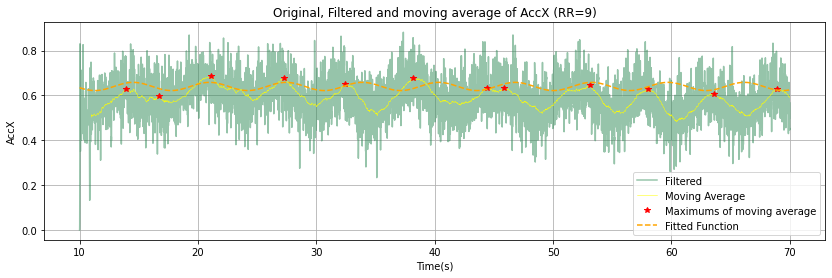

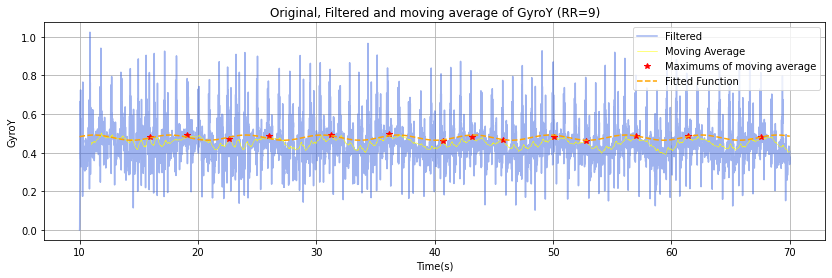

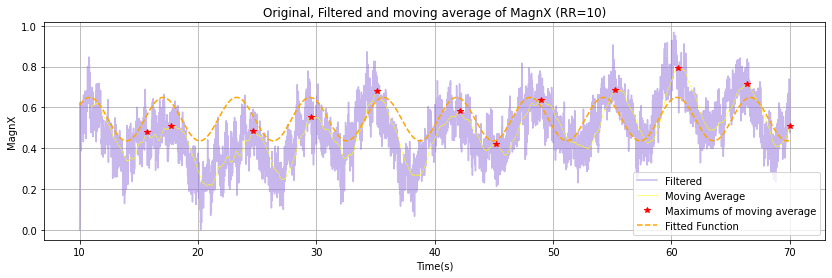

In [42]:

moving_avg =df_filtered.apply(lambda x: x.rolling(window=fs).mean())
max_mva = moving_avg.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))

def f2(x, A, nu, B):
    return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency    

x = np.linspace(0, df_filtered.index.stop/fs, df_filtered.index.stop)
  
    
RR_mva = []
for i,c in enumerate(df_filtered.columns):


    _p = [x+df_filtered.index.start for x in list(max_mva[c][0])]
    _d = moving_avg[c] 
      

    popt, pcov = sp.optimize.curve_fit(f2, x[_p], _d[_p])
    
    RR_mva.append(60*popt[1]/np.pi/2)
    print(f'{c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
    
    
    if c in  ['AccX', 'GyroY', 'MagnX']:
        fig, ax = plt.subplots(1, 1, figsize = (14, 4))
        xx = x[df_filtered.index.start:]
        
        ax.plot(xx , df_filtered[c], alpha=0.5, color=colors[i], label='Filtered')
        ax.plot(xx , _d, color='yellow', linewidth=0.5, label='Moving Average')  
        ax.plot(x[_p], _d[_p],'*',color='red', label='Maximums of moving average')
        ax.plot(xx, f2(xx, popt[0], popt[1], popt[2]), color='orange',linestyle='--', label='Fitted Function')

        ax.set_xlabel('Time(s)')
        ax.set_ylabel(c)
        ax.set_title(f'Original, Filtered and moving average of {c} (RR={RR_mva[i]:.0f})')
        ax.legend()
        ax.grid() 
    


print(25*'*')
print(f'Calculated RR by using moving average in time domain is {mean(RR_mva):2.0f} bpm. ')


In [43]:
#filter_freq = [0,40]
#method2(df, fs, filter_freq, twnd, features=selected_features)

## 3.2.3. Method 3

**method 3** is very similar to method 2. The only difference is that instead of moving average, we fit a function on relative extrema of signal in each *fs* samples. We motivated to do this since it would be posible to find more parameters if needed, for example by using smaller window when finding extrama, HR will be obtained.

> **Note:** *method3 internally performs filtering. So the sampling dataframe should passed to it.*


Here we show how method3 works. We just visualize the result on three features ['AccX', 'GyroY', 'MagnX'].

AccX: freq. = 0.16 ==> RR = 10 bpm.
AccY: freq. = 0.16 ==> RR = 10 bpm.
AccZ: freq. = 0.16 ==> RR = 10 bpm.
GyroX: freq. = 0.16 ==> RR = 10 bpm.
GyroY: freq. = 0.16 ==> RR = 10 bpm.
GyroZ: freq. = 0.16 ==> RR = 10 bpm.
MagnX: freq. = 0.16 ==> RR = 10 bpm.
MagnY: freq. = 0.16 ==> RR = 10 bpm.
MagnZ: freq. = 0.16 ==> RR =  9 bpm.
*************************
Calculated RR by using moving average in time domain is 10 bpm. 


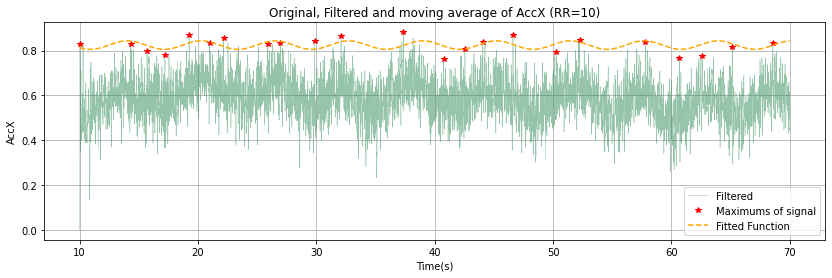

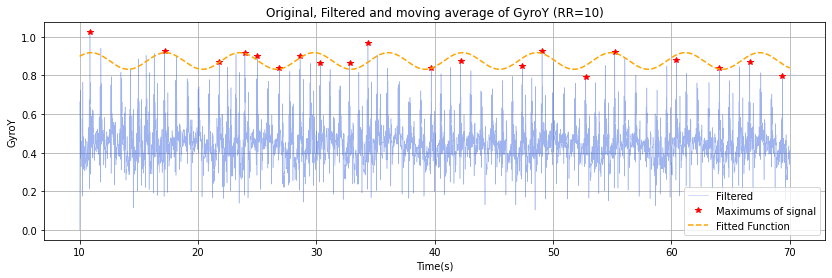

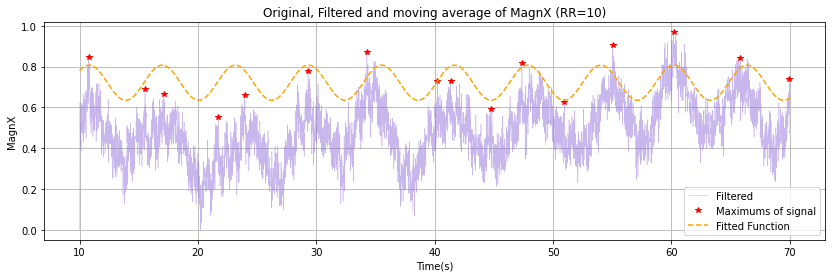

In [44]:
max_sig = df_filtered.apply(lambda x: signal.argrelextrema(np.array(x), np.greater, order=fs))

def f3(x, A, nu, B):
    return A * np.sin(nu * x) + B # sine function with amplitude A and angular frequency    

x = np.linspace(0, df_filtered.index.stop/fs, df_filtered.index.stop)
  
    
RR_sig = []
for i,c in enumerate(df_filtered.columns):

    _p = [x+df_filtered.index.start for x in list(max_sig[c][0])]
    _d = df_filtered[c] 
      

    popt, pcov = sp.optimize.curve_fit(f3, x[_p], _d[_p])
    
    RR_sig.append(60*popt[1]/np.pi/2)
    print(f'{c}: freq. = {popt[1]/np.pi/2:.2f} ==> RR = {60*popt[1]/np.pi/2:2.0f} bpm.')    
    
    
    
    
    if c in  ['AccX', 'GyroY', 'MagnX']:
        fig, ax = plt.subplots(1, 1, figsize = (14, 4))

        xx = x[df_filtered.index.start:]
        
        ax.plot(xx , df_filtered[c], alpha=0.5, linewidth=0.5,color=colors[i], label='Filtered')
        ax.plot(x[_p], _d[_p],'*',color='red', label='Maximums of signal')
        ax.plot(xx, f3(xx, popt[0], popt[1], popt[2]), color='orange', linestyle='--', label='Fitted Function')

        ax.set_xlabel('Time(s)')
        ax.set_ylabel(c)
        ax.set_title(f'Original, Filtered and moving average of {c} (RR={RR_sig[i]:.0f})')
        ax.legend()
        ax.grid() 
    


print(25*'*')
print(f'Calculated RR by using moving average in time domain is {mean(RR_sig):2.0f} bpm. ')


In [45]:
#filter_freq = [0,40]
#method3(df, fs, filter_freq, twnd, features=selected_features)

# 4. Metrics

# 5. Optional part

**method2** and **method3** work even if filtering fails. Here we call method2 with *nofilter = True*.

AccX: freq. = 0.16 ==> RR =  9 bpm.
GyroY: freq. = 0.16 ==> RR =  9 bpm.
MagnX: freq. = 0.17 ==> RR = 10 bpm.
*************************
Calculated RR by using moving average in time domain is 10 bpm. 


[9.32548707107926, 9.459802663917904, 10.439704610991388]

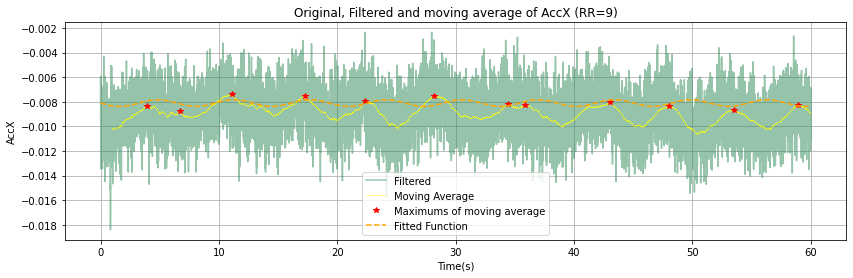

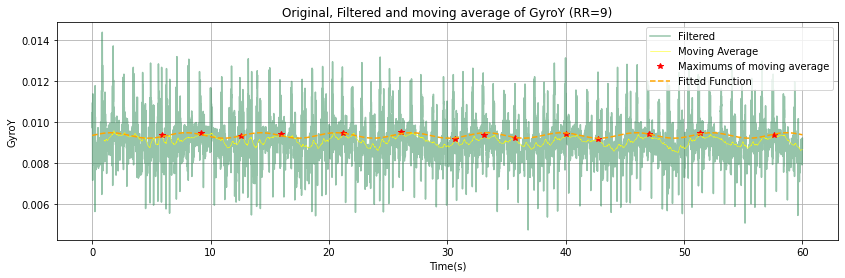

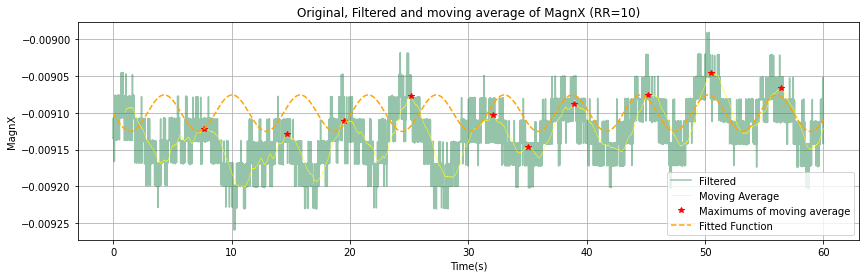

In [46]:
selected_features =  ['AccX', 'GyroY', 'MagnX']
method2(df, fs, filter_freq, twnd, features=selected_features, nofilter=True)

# 6. Conclusion

Three different methods for finding RR was proposed. The first one works in the frequency domain, while other two methods work in time domain. Although the first one is very sensitive to selected frequency band and will not work if filtering fails, the others are stable and work even if filtering fails or not done at all.